In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from datetime import datetime
import math
import networkx as nx
import warnings
warnings.simplefilter(action='ignore')

plt.style.use('seaborn-darkgrid')
%matplotlib inline

FIG_SIZE = (13,6)

# Analysing topic data

In [2]:
user_df = pd.read_csv("filestore/user/fact_user_dataset.csv").drop('Unnamed: 0',axis=1)
topics_df = pd.read_csv("filestore/user/dim_topics.csv").drop('Unnamed: 0',axis=1)

# There seems to be a user with joined = nan, filter them out
user_df = user_df[~user_df['joined'].isnull()]
topics_df['topic_id'] = topics_df['topic_id'].astype(object)

In [3]:
def convert_posix_time(t):
    return datetime.utcfromtimestamp(t / 1000)

In [4]:
user_df['joined'] = user_df['joined'].apply(convert_posix_time)
user_df['visited'] = user_df['visited'].apply(convert_posix_time)

In [5]:
user_df.head()

,bio,city,country,hometown,user_id,joined,lat,link,lon,name,state,status,topics,visited
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,2017-04-18 22:36:19,53.33,http://www.meetup.com/members/203627719,-6.25,Niamh Donnelly,NaN,active,15236,2019-02-19 14:48:46
1,NaN,Anyang,kr,NaN,236920397,2018-01-10 10:55:54,37.39,http://www.meetup.com/members/236920397,126.92,A Yeon Choi,NaN,active,"50881,563,26212,67622,48471,3833",2018-01-10 10:55:54
2,NaN,Dublin,ie,NaN,202430831,2019-03-23 10:51:08,53.33,http://www.meetup.com/members/202430831,-6.25,Aakanksha Rana,NaN,active,"59430,18551,65780,8476,48471,108403,682,9696,563",2019-04-08 07:36:11
3,NaN,Paris,fr,NaN,129312012,2016-02-12 22:08:19,48.86,http://www.meetup.com/members/129312012,2.34,abdobim,NaN,active,"189,2260,16216,20346,21441,51642,9696,10306,10...",2016-02-14 21:20:05
4,NaN,Dublin,ie,NaN,242392259,2017-11-28 17:14:11,53.33,http://www.meetup.com/members/242392259,-6.25,Abheri Dutta,NaN,active,"9696,15236,1924,8476,223,6144,39173,9349,206,1...",2018-06-19 10:58:20


In [6]:
user_df.dtypes

bio                 object
city                object
country             object
hometown            object
user_id              int64
joined      datetime64[ns]
lat                float64
link                object
lon                float64
name                object
state               object
status              object
topics              object
visited     datetime64[ns]
dtype: object

In [7]:
topics_df.head()

,urlkey,name,topic_id,target
0,business-networking,professional-networking,15236,pyladiesdublin
1,international-friends,International Friends,50881,pyladiesdublin
2,opensource,Open Source,563,pyladiesdublin
3,language-exchange,Language Exchange,26212,pyladiesdublin
4,culture-exchange,Culture Exchange,67622,pyladiesdublin


In [8]:
topics_df.dtypes

urlkey      object
name        object
topic_id    object
target      object
dtype: object

### Preparing the data

In [9]:
# There are some nulls in the data, remove them
user_df['topics'][user_df['topics'].isnull()] = '-'

In [10]:
user_topics = pd.DataFrame(
    user_df['topics']
    .str.split(',')
    .tolist(), index=user_df['user_id']) \
    .stack() \
    .reset_index([0, 'user_id'])
user_topics.columns = ['user_id', 'topic_id']
user_topics

,user_id,topic_id
0,203627719,15236
1,236920397,50881
2,236920397,563
3,236920397,26212
4,236920397,67622
...,...,...
12103,195659013,128595
12104,195659013,15582
12105,195659013,408
12106,236223844,48471


In [11]:
users_long = pd.merge(user_df, user_topics, on='user_id')
users_long.drop(['joined', 'lat','link', 'lon', 'state', 'status', 'visited', 'topics'], axis=1)

,bio,city,country,hometown,user_id,name,topic_id
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,Niamh Donnelly,15236
1,NaN,Anyang,kr,NaN,236920397,A Yeon Choi,50881
2,NaN,Anyang,kr,NaN,236920397,A Yeon Choi,563
3,NaN,Anyang,kr,NaN,236920397,A Yeon Choi,26212
4,NaN,Anyang,kr,NaN,236920397,A Yeon Choi,67622
...,...,...,...,...,...,...,...
12103,NaN,Dublin,ie,Odense,195659013,Zoltán,128595
12104,NaN,Dublin,ie,Odense,195659013,Zoltán,15582
12105,NaN,Dublin,ie,Odense,195659013,Zoltán,408
12106,NaN,Dublin,ie,NaN,236223844,于琳雅,48471


In [12]:
# Remove duplicates, convert id to string for matching
unique_topics = topics_df.drop_duplicates()
unique_topics['topic_id'] = unique_topics['topic_id'].apply(lambda x: str(x))
unique_topics.columns = [c if c!='name' else 'topic_name' for c in unique_topics.columns]

In [13]:
unique_topics.columns

Index(['urlkey', 'topic_name', 'topic_id', 'target'], dtype='object')

In [14]:
user_topics = pd.merge(users_long, unique_topics, on='topic_id', how='left') \
    .loc[:, ['name', 'topic_name', 'topic_id']]

In [15]:
def top_n_barplot(df, col, start=0, end=15, rot=45):
    data = df[col].value_counts()[start:end]
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    x = data.index.tolist()
    
    ax.bar(x=x, height=data)
    ax.set_xlim(xmin=-0.5, xmax=len(x))

    bar_list = ax.patches
    for bar, label in zip(bar_list, data):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, label,
                ha='center', va='bottom')

    plt.xticks(rotation=rot)
    plt.style.use('seaborn-darkgrid')
    plt.show()

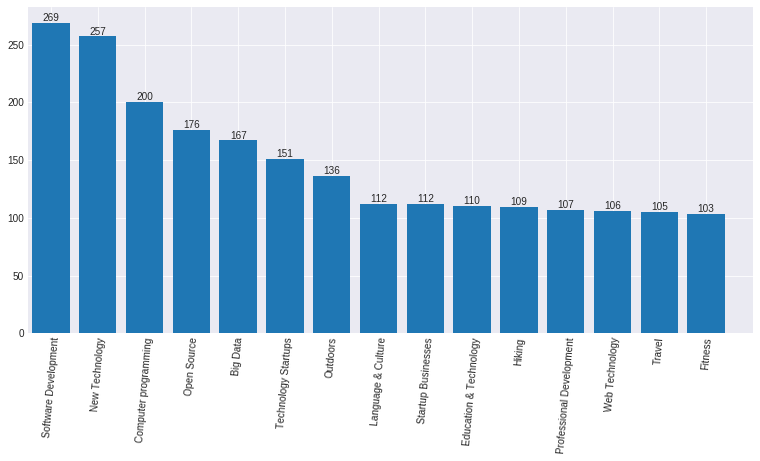

In [16]:
top_n_barplot(user_topics, 'topic_name', rot=85)

## Convert the dataframe to graph

In [17]:
user_topics

,name,topic_name,topic_id
0,Niamh Donnelly,professional-networking,15236
1,A Yeon Choi,International Friends,50881
2,A Yeon Choi,Open Source,563
3,A Yeon Choi,Language Exchange,26212
4,A Yeon Choi,Culture Exchange,67622
...,...,...,...
12103,Zoltán,Internet Startups,128595
12104,Zoltán,Web Development,15582
12105,Zoltán,Vegan,408
12106,于琳雅,Computer programming,48471


In [18]:
def create_hash_key(df):
    f = lambda x: hash(x)
    df['h1'] = df['source'].apply(f)
    df['h2'] = df['target'].apply(f)
    df['hashed_key'] = df['h1'] ^ df['h2']
    return df.drop(['h1', 'h2'], axis=1)

Create a hash key which is a unique identifies for each pair (source, target).
That is, if there are two rows with values, (A,B) and (B,A), they are treated as the same

In [19]:
cartesian = pd.merge(user_topics, user_topics, on='name')
cartesian = cartesian[cartesian['topic_name_x'] != cartesian['topic_name_y']].reset_index()
cartesian = cartesian[['topic_name_x', 'topic_name_y']] 
cartesian.columns = ['source', 'target']
cartesian = create_hash_key(cartesian)

In [20]:
len(cartesian)

376703

Count the number of times each pair of topics appear.

In [21]:
hash_edge_count = cartesian.groupby('hashed_key', as_index=False)['source'].count()
hash_edge_count['source'] = hash_edge_count['source']-1
hash_edge_count.rename({'source':'weight'}, axis=1, inplace=True)

Create ref table for each topic pair and its hash

In [22]:
topic_hash_map = cartesian.groupby('hashed_key', as_index=False)['source', 'target'].first()

In [23]:
topic_edges = pd.merge(topic_hash_map, hash_edge_count, on='hashed_key').drop(['hashed_key'], axis=1)
topic_edges.sort_values(['source', 'weight'], ascending=False).head(10)

,source,target,weight
72322,wine-and-food-pairing,Education,43
15413,wine-and-food-pairing,Software Development,33
51650,wine-and-food-pairing,"Eating, Drinking, Talking, Laughing, Etc",29
34026,wine-and-food-pairing,Big Data,27
20644,wine-and-food-pairing,Art,23
65346,wine-and-food-pairing,Education & Technology,23
50288,wine-and-food-pairing,Watching Movies,21
55131,wine-and-food-pairing,Professional Development,19
57201,wine-and-food-pairing,Web Technology,19
41319,wine-and-food-pairing,International Travel,17


In [83]:
len(topic_edges)

83953

Data is in the right shape, but there are too many edges with weight 1

In [24]:
topic_edges['weight'].value_counts()

1      57396
3      11126
5       4816
7       2714
9       1697
       ...  
209        1
335        1
207        1
141        1
155        1
Name: weight, Length: 85, dtype: int64

In [25]:
topic_edges[topic_edges['weight']>80]['weight'].value_counts()

83     10
81      8
91      8
89      7
103     7
97      6
85      6
95      6
87      5
93      5
101     5
113     4
133     2
143     2
123     2
131     2
99      2
107     2
109     2
115     2
117     2
119     2
227     1
155     1
267     1
135     1
213     1
137     1
139     1
141     1
229     1
163     1
157     1
209     1
207     1
233     1
335     1
221     1
111     1
105     1
285     1
127     1
Name: weight, dtype: int64

Lets start with a graph for edges with weight > 80

In [28]:
G_80_weight = nx.from_pandas_edgelist(
    topic_edges[topic_edges['weight']>80],
    edge_attr=True)

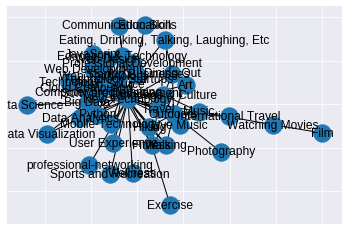

In [29]:
nx.draw_networkx(G_80_weight)

In [36]:
G = nx.from_pandas_edgelist(
    topic_edges,
    edge_attr=True)

## Creating some centrality metrics

In [98]:
graph_measures = {
    'degree_centrality' : nx.degree_centrality,
    'betweenness_centrality' : nx.betweenness_centrality,
    'eigenvector_centrality' : nx.eigenvector_centrality,
    'pagerank_centrality' : nx.pagerank
}

def get_measure(df, measure):
    G = nx.from_pandas_edgelist(df)
    measure_df = (
        pd.DataFrame({
            k:[v] 
            for k,v 
            in graph_measures[measure](G).items()
        })
        .T
        .reset_index()
        .rename({'index':'source', 0: measure},axis=1))
    return pd.merge(df, measure_df, on='source').drop_duplicates()

Since the full network is very large, let's start by considering only edges with weight> 80 

In [104]:
edges_gt80_df = topic_edges[topic_edges['weight']>80]
for k,v in graph_measures.items():
    edges_gt80_df = get_measure(edges_gt80_df, k)

G_80_weight = nx.from_pandas_edgelist(
    edges_gt80_df,
    edge_attr=True)
nx.write_graphml(G_80_weight, './networks/topic_network_80_weight.graphml')

Doing the same for the full network

In [105]:
graph_df = topic_edges
for k,v in graph_measures.items():
    graph_df = get_measure(graph_df, k)

G = nx.from_pandas_edgelist(
    graph_df,
    edge_attr=True)
nx.write_graphml(G, './networks/topic_network.graphml')